# **Deep learning project - Siamese CNN in painter by numbers dataset**


***Submitted by:***

***Aya Mahagna  314774639*** 

***Atheer AboFuol  314642273***



**Imports and loading data path and device:**

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import os
import zipfile
import random
import io

root_path = '/kaggle/input/painter-by-numbers'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Showing 10 columns of the dataset table:**

In [3]:
df = pd.read_csv(root_path+'/all_data_info.csv')
df.head(10)

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg
6,Barnett Newman,NaN,abstract,7345.0,8640.0,6383948.0,wikiart,Color Field Painting,"Who’s Afraid of Red, Yellow and Blue II",train_only,True,62252.jpg
7,Hiroshige,1838,bird-and-flower painting,6483.0,9276.0,12762418.0,wikiart,Ukiyo-e,Small Bird on a Branch of Kaidozakura,train_and_test,False,49823.jpg
8,Barnett Newman,1963.0,abstract,6049.0,8206.0,1135960.0,wikiart,Color Field Painting,Black Fire I,train_only,True,63861.jpg
9,Franz Richard Unterberger,NaN,cityscape,6238.0,7352.0,7896792.0,wikiart,Romanticism,Procession in Naples,train_and_test,False,84512.jpg


**Some data analysis / statics:**

In [6]:
print(f"The dataset contains a total of {len(df['artist'].unique())} different artists .")
print(f"The dataset contains a total of {len(df['genre'].unique())} different painting genres.")
print(f"The dataset contains a total of {len(df)} different images/paintaings.")
print(f"The 10 artists with the most paintings available in the dataset are:\n{df['artist'].value_counts().head(10)}")
train_only = len([x for x in df["artist_group"].values if x == 'train_only'])
print(f"The total of the data which is for train only is: {train_only}")
test_only = len([x for x in df["artist_group"].values if x == 'test_only'])
print(f"The total of the data which is for test only is: {test_only}")
train_and_test = len([x for x in df["artist_group"].values if x == 'train_and_test'])
print(f"The total of the data which is for train and test: {train_and_test}")


The dataset contains a total of 2319 different artists .
The dataset contains a total of 43 different painting genres.
The dataset contains a total of 103250 different images/paintaings.
The 10 artists with the most paintings available in the dataset are:
Ivan Aivazovsky               500
John Singer Sargent           500
Pierre-Auguste Renoir         500
Marc Chagall                  500
Pablo Picasso                 500
Zdislav Beksinski             500
Ivan Shishkin                 500
Gustave Dore                  500
Ilya Repin                    500
Giovanni Battista Piranesi    500
Name: artist, dtype: int64
The total of the data which is for train only is: 14164
The total of the data which is for test only is: 2936
The total of the data which is for train and test: 86150


****Displaying 5 random images with name of their arists:****

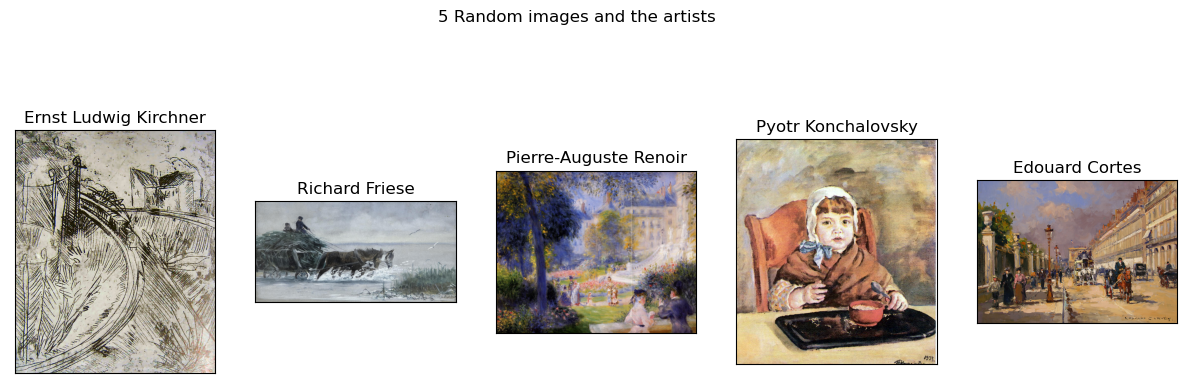

In [7]:
import random
plt.figure(figsize=(20,10))

for i in range(1,6):
    train_file = zipfile.ZipFile(root_path+"/train.zip", 'r')
    random_image = random.choice(train_file.namelist())
    image = Image.open(train_file.open(random_image))
    plt.subplot(1, 5, i)
    name=random_image.split("train/", 1)[1]
    row = df.loc[df['new_filename'] == name]
    if row.size>0:
        artist = row['artist'].values[0]
    else:
        artist=""
    plt.title(artist)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.asarray(image))
plt.show()

**Changa the size of all images on the train and test to 256*256:**

In [8]:
def change_size(source_dir, destination_dir, archive_name):
    resized_images = []
    with zipfile.ZipFile(source_dir + '/' + archive_name + '.zip', 'r') as source_archive:
        # Loop through all files in the archive
        for file_path in source_archive.namelist():
            # Skip files that are not JPGs
            if not "jpg" in file_path:
                continue
            else:
                # Extract the image name from the file path
                image_name = file_path[len(archive_name)+1:]

            try:
                # Open the image and resize it
                with source_archive.open(file_path) as image_data:
                    image = Image.open(image_data)
                    tensor_image = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])(image)
                    image = transforms.ToPILImage()(tensor_image)

                    # Save the resized image as a PNG 
                    file_object = io.BytesIO()
                    image.save(file_object, 'PNG')
                    image.close()

                    # Append the image name and BytesIO object to the list of resized images
                    resized_images.append([image_name, file_object])
            except Image.DecompressionBombError:
                print(f"DecompressionBombError")
            except Exception as e:
                print(f" Error")

    # Create a new archive and add the resized images to it
    with zipfile.ZipFile(destination_dir + '/' +'new' + archive_name + '.zip', 'w') as destination_archive:
        for image_name, bytes_stream in resized_images:
            destination_archive.writestr(archive_name + '/' + image_name, bytes_stream.getvalue())


path_from =root_path
path_to = "/kaggle/working"
# change_size(path_from, path_to, "test")
# change_size(path_from, path_to, "train")


In [4]:
# Used https://www.kaggle.com/code/spyrosrigas/20-painters-classification-with-cnns-and-svms/notebook to 
# # to help us in the implementation
class SimpleDataSet:
    def __init__(self, zip_name, data_frame,is_train = True):

        self.data_frame = data_frame.reset_index(drop=True)
        self.zip_name = zip_name
        self.train_zip_path = root_path+"/"+zip_name + ".zip"
        self.zip_name+= '/'
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.tensorTransform = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        self.train_zip = zipfile.ZipFile(self.train_zip_path, 'r')

        if is_train:
            self.rearange_data(min_images=20, max_images=510, most_frequent=None)
        else:
            self.rearange_data(min_images=0, max_images=510, most_frequent=None)
        self.train_images_files = self.data_frame.iloc[:, 11].values
        self.train_labels = self.data_frame.iloc[:, 0].values
        self.train_index = self.data_frame.index.values
        self.choose_samples(150, 15)

    def rearange_data(self, min_images, max_images, most_frequent = None):
        images = []
        for image_name in self.train_zip.namelist():
            images.append(image_name[len(self.zip_name):])
        self.data_frame = self.data_frame.loc[self.data_frame['new_filename'].isin(images)]
        data_count = self.data_frame['artist'].value_counts()[:most_frequent]
        self.data_frame = self.data_frame[self.data_frame['artist'].isin(data_count[data_count > min_images].index) & self.data_frame['artist'].isin(data_count[data_count < max_images].index)]
        self.data_frame = self.data_frame.reset_index(drop=True)

    def choose_samples(self, n, num_samples=20):
        data_count = self.data_frame['artist'].value_counts()[:num_samples]
        data_frame_filter = self.data_frame[self.data_frame['artist'].isin(data_count.index)].reset_index(drop=True)
        train_index_filter = data_frame_filter.index.values
        train_labels_filter = data_frame_filter.iloc[:, 0].values
        indexes = np.random.choice(train_index_filter, n)
        n_samples = torch.empty((0, 3, 256, 256))
        labels = []
        for index in indexes:
            file_name = self.train_images_files[index]
            image_data = self.train_zip.open(self.zip_name + file_name)
            image = Image.open(image_data)
            label = train_labels_filter[index]
            image = self.tensorTransform(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], 0)
            if image.shape[0] == 4:
                image = image[0:3]
            image = self.normalize(image)

            n_samples = torch.cat([n_samples, torch.reshape(image, (1, 3,256, 256))], 0)
            labels.append(label)
        self.n_samples = n_samples
        self.labels = labels

class PairDataSet(Dataset, SimpleDataSet):
    def __init__(self, file_name, data_frame, is_train = True):
        SimpleDataSet.__init__(self, file_name, data_frame,is_train)

    def __len__(self):
        return len(self.data_frame)
    
# Creates pairs of images (one current image and one pos or neg image) for training a Siamese neural network. It takes an index as input and returns a tuple containing a tensor with two images and a binary label indicating whether the two images are a pos or neg pair.
    def __getitem__(self, index):
        try:
            current_file_name = self.train_images_files[index]
            current_image_info = self.train_zip.open(self.file_name + current_file_name)
            current_image = Image.open(current_image_info)
            current_label = self.train_labels[index]
            label = random.randint(0, 1)  #1 if same artist 0 if not, first we give random value
            if label:
                indexes_list = np.array(self.train_labels[self.train_index!=index]==current_label)
                second_list = np.array(self.train_index[self.train_index!=index])
                second_list = second_list[indexes_list]

                if(len(second_list) == 0):
                    raise Exception("Couldn't find matching image")
                else:
                    pos_index = random.choice(second_list)

                second_file_name = self.train_images_files[pos_index]
                second_image_info = self.train_zip.open(self.file_name + second_file_name)
                second_image = Image.open(second_image_info)

            else:
                second_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=current_label]
                second_index = random.choice(second_list)
                second_file_name = self.train_images_files[second_index]
                second_image_info = self.train_zip.open(self.file_name + second_file_name)
                second_image = Image.open(second_image_info)

            current_image = self.tensorTransform(current_image)
            second_image = self.tensorTransform(second_image)

            if current_image.shape[0] == 1:
                current_image = torch.cat([current_image, current_image, current_image], 0)
            if current_image.shape[0] == 4:
                current_image = current_image[0:3]
            if second_image.shape[0] == 1:
                second_image = torch.cat([second_image, second_image, second_image], 0)
            if second_image.shape[0] == 4:
                second_image = second_image[0:3]
            current_image = self.normalize(current_image)
            second_image = self.normalize(second_image)

            images = torch.stack(([current_image, second_image]))
            return images, float(label)

        except Exception as e:
            return torch.empty(3, 3, 256, 256), "not_labeled"
        except Image.DecompressionBombError:
            return torch.empty(3, 3, 256, 256), "not_labeled"


In [7]:
class TripletDataSet(Dataset, SimpleDataSet):
    def __init__(self, zip_name, data_frame, is_train = True):
        SimpleDataSet.__init__(self, zip_name, data_frame, is_train)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        try:
            current_file_name = self.train_images_files[index]
            current_image_data = self.train_zip.open(self.zip_name + current_file_name)
            current_image = Image.open(current_image_data)
            current_label = self.train_labels[index]
            indices = np.array(self.train_labels[self.train_index!=index]==current_label)
            pos_list = np.array(self.train_index[self.train_index!=index])
            pos_list = pos_list[indices]
            if(len(pos_list) == 0):
                raise Exception("Error")
            else:
                pos_index = random.choice(pos_list)
            pos_file_name = self.train_images_files[pos_index]
            pos_image_data = self.train_zip.open(self.zip_name + pos_file_name)
            pos_image = Image.open(pos_image_data)

            neg_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=current_label]
            neg_index = random.choice(neg_list)
            neg_file_name = self.train_images_files[neg_index]
            neg_image_data = self.train_zip.open(self.zip_name + neg_file_name)
            neg_image = Image.open(neg_image_data)
            current_image = self.tensorTransform(current_image)
            pos_image = self.tensorTransform(pos_image)
            neg_image = self.tensorTransform(neg_image)
            if current_image.shape[0] == 1:
                current_image = torch.cat([current_image, current_image, current_image], 0)
            if current_image.shape[0] == 4:
                current_image = current_image[0:3]
            if pos_image.shape[0] == 1:
                pos_image = torch.cat([pos_image, pos_image, pos_image], 0)
            if pos_image.shape[0] == 4:
                pos_image = pos_image[0:3]
            if neg_image.shape[0] == 1:
                neg_image = torch.cat([neg_image, neg_image, neg_image], 0)
            if neg_image.shape[0] == 4:
                neg_image = neg_image[0:3]
            current_image = self.normalize(current_image)
            pos_image = self.normalize(pos_image)
            neg_image = self.normalize(neg_image)
            images = torch.stack(([current_image, pos_image, neg_image]))
            return images, current_label
        except Exception as e:
            return torch.empty(3, 3, 256, 256), "none_labeled"
        except Image.DecompressionBombError:
            return torch.empty(3, 3, 256, 256), "none_labeled"
            
# Similar to TripletMarginLoss help us calculate the loss using euclidian distance when 
# given 3 images one is the current image and one positive (painted by same artist) and one 
# is negative(painted by different artist)

class LossCalculation(nn.Module):
    def __init__(self, margin=0.5):
        super(LossCalculation, self).__init__()
        self.margin = margin

    def euclidean_distance(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def predict(self, current, pos, neg):
        distance_pos = self.euclidean_distance(current, pos)
        distance_neg = self.euclidean_distance(current, neg)
        predictions = distance_pos < distance_neg
        losses = torch.relu(distance_pos - distance_neg + self.margin)
        return losses.mean(), predictions

    def forward(self, current, pos, neg):
        distance_pos = self.euclidean_distance(current, pos)
        distance_neg = self.euclidean_distance(current, neg)
        losses = torch.relu(distance_pos - distance_neg + self.margin)
        return losses.mean()


In [11]:
class CNN(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
             nn.Conv2d(3, 32, kernel_size=3),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(32, 64, kernel_size=3),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(64, 128, kernel_size=3),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(128, 256, kernel_size=3),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
         )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layers(x)
        return x
    
class SiameseCNN(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super(SiameseCNN, self).__init__()

        self.num_nets = 10

        # Create a list of identical networks
        self.nets = nn.ModuleList([CNN() for _ in range(self.num_nets)])

        # Freeze the parameters of all networks
        for net in self.nets:
            for parameter in net.parameters():
                parameter.requires_grad = False

            self.fc = nn.Sequential(
            nn.Linear(1024*10, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512)
        )

    def forward_once(self, x, net_idx):
        x = self.nets[net_idx](x)
        return x.view(x.shape[0], -1)

    def forward(self, x):
        xs = [self.forward_once(x, i) for i in range(self.num_nets)]
        x = self.fc(torch.cat(xs, dim=1))
        return x

In [12]:
# Calculates accuracy and loss every epoch for training
def run_training(train_loader, model, set_type = "train", criterion = LossCalculation()):
    total_attempts = 0
    total_successes = 0
    losses = []

    for step, (inputs, labels) in tqdm(enumerate(train_loader), desc="Steps"):
        if ((step + 1) % 50 == 0):
            break

        if any(label == "not_labeled" for label in labels):
            continue

        current_img = inputs[:, 0, :, :, :]
        pos_img = inputs[:, 1, :, :, :]
        neg_img = inputs[:, 2, :, :, :]

        current_img = current_img.to(device)
        pos_img = pos_img.to(device)
        neg_img = neg_img.to(device)

        current_out = model(current_img)
        pos_out = model(pos_img)
        neg_out = model(neg_img)

        loss, prediction = criterion.predict(current_out, pos_out, neg_out)
        losses.append(loss.cpu().detach().numpy())
        total_successes += sum(prediction.cpu()).item()
        total_attempts += prediction.cpu().shape[0]
    success_rate = total_successes/total_attempts

    if set_type == "validation":
        print(f"Validation success: {(success_rate):0.2f}")
    elif set_type == "train":
        print(f"Training success: {(success_rate):0.2f}")
    elif set_type == "test":
        print(f"Test success: {(success_rate):0.2f}")

    return np.mean(losses), success_rate


# Calculates accuracy for testing
def run_testing(test_loader, model, criterion = LossCalculation().to(device)):
  total_attempts = 0
  total_successes = 0
  for step, (inputs, labels) in tqdm(enumerate(test_loader), desc="Steps"):
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue
        first_img = inputs[:, 0, :, :, :].to(device)
        second_img = inputs[:, 1, :, :, :].to(device)
        first_out = model(first_img)
        second_out = model(second_img)
        distances = (first_out - second_out).pow(2).sum(1)
        predictions = (distances < 0.4).int().cpu().view(-1)
        total_successes += sum(predictions == labels.int()).item()
        total_attempts += labels.shape[0]
  success_rate = total_successes/total_attempts
  print(f"Test Success: {(success_rate):0.2f}")
  return success_rate


In [18]:
def train(train_data_frame, validation_data_frame, model, epochs = 100, batch_size = 32, zip_name = "train"):
    current_steps = 2
    min_loss = 10
    min_validation_loss = 10
    patience_steps = 5
    current_epoch = 0
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    triplet_loss = LossCalculation(0.25)
    validation_loader_ds = TripletDataSet(zip_name, validation_data_frame)
    validation_loader = DataLoader(validation_loader_ds, batch_size=batch_size, num_workers=0, shuffle=True)
    train_loader_ds = TripletDataSet(zip_name, train_data_frame)
    train_loader = DataLoader(train_loader_ds, batch_size=batch_size, num_workers=0, shuffle=True)
    training_loss_list = []
    training_accuracy_list = []
    validation_losses = []
    validation_accuracy_list = []
    for epoch in range(epochs):
        current_epoch+= 1
        print(f"epoch {epoch+1}")
        training_losses = []
        for step, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            to_continue = False
            for i in range(len(labels)):
                if labels[i] == "none_labeled":
                    to_continue=True
            if to_continue:
                continue
            current_img = inputs[:,0,:,:,:].to(device)
            pos_img = inputs[:,1,:,:,:].to(device)
            neg_img = inputs[:,2,:,:,:].to(device)

            current_out = model(current_img)
            pos_out = model(pos_img)
            neg_out = model(neg_img)

            loss = triplet_loss(current_out, pos_out, neg_out)

            loss.backward()
            optimizer.step()

            training_losses.append(loss.cpu().detach().numpy())
        current_loss = np.mean(training_losses)
        print("Training Loss: {:.2f}".format(current_loss))
        training_loss, training_success_rate = run_training(train_loader, model, "train", triplet_loss)
        validation_loss, validation_success_rate = run_training(validation_loader, model, "validation", triplet_loss)

        training_loss_list.append(training_loss)
        training_accuracy_list.append(training_success_rate)
        validation_losses.append(validation_loss)
        validation_accuracy_list.append(validation_success_rate)

        if validation_loss < min_validation_loss:
            min_validation_loss = validation_loss
            patience_steps = 5
        else:
            patience_steps -= 1
            if patience_steps == 0:
                break

        if current_loss < min_loss * 0.95:
                min_loss = current_loss
                current_steps = 2
        else:
            current_steps = current_steps - 1
            if current_steps == 0:
                scheduler.step()
                current_steps = 2
        if training_loss < 0.01:
            break

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(range(current_epoch), training_accuracy_list)
    plt.plot(range(current_epoch), validation_accuracy_list)
    plt.legend(['Train', 'Validation'])
    plt.subplot(1, 2, 2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(current_epoch), training_loss_list)
    plt.plot(range(current_epoch), validation_losses)
    plt.legend(['Train', 'Validation'])
    plt.plot()

**Prepare the data frames:**

In [ ]:
train_data = pd.DataFrame({})
test_data = pd.DataFrame({})
images_artist = df['artist'].value_counts()
artists = [images_artist.index[i] for i in range(len(images_artist)) if images_artist[i] > 5]
for artist in artists:
    artist_data = df[(df['artist']==artist)]
    artist_train_data = artist_data.loc[(artist_data.in_train == True)]
    artist_test_data = artist_data.loc[(artist_data.in_train == False)]
    train_data = pd.concat([train_data, artist_train_data])
    test_data = pd.concat([test_data, artist_test_data])
train_count = train_data["artist"].value_counts()[:200]
validation_data = train_data[train_data['artist'].isin(list(train_count.index))].reset_index(drop=True)
for i in range(10):
    chosen_artists = np.random.choice(validation_data["artist"].unique(), 20)
    current_data = validation_data[validation_data['artist'].isin(list(chosen_artists))]
    mask = validation_data['artist'].isin(current_data['artist'])
    validation_data = validation_data[~mask].reset_index(drop=True)


**Here we'll train the model:**

Training:

epoch 1
Training Loss: 0.23


Steps: 0it [00:00, ?it/s]

Training success: 0.61


Steps: 0it [00:00, ?it/s]

Validation success: 0.61
epoch 2
Training Loss: 0.23


Steps: 0it [00:00, ?it/s]

Training success: 0.62


Steps: 0it [00:00, ?it/s]

Validation success: 0.61
epoch 3
Training Loss: 0.22


Steps: 0it [00:00, ?it/s]

Training success: 0.63


Steps: 0it [00:00, ?it/s]

Validation success: 0.61
epoch 4
Training Loss: 0.22


Steps: 0it [00:00, ?it/s]

Training success: 0.62


Steps: 0it [00:00, ?it/s]

Validation success: 0.65
epoch 5
Training Loss: 0.20


Steps: 0it [00:00, ?it/s]

Training success: 0.66


Steps: 0it [00:00, ?it/s]

Validation success: 0.66
epoch 6
Training Loss: 0.20


Steps: 0it [00:00, ?it/s]

Training success: 0.67


Steps: 0it [00:00, ?it/s]

Validation success: 0.66
epoch 7
Training Loss: 0.19


Steps: 0it [00:00, ?it/s]

Training success: 0.66


Steps: 0it [00:00, ?it/s]

Validation success: 0.67
epoch 8
Training Loss: 0.19


Steps: 0it [00:00, ?it/s]

Training success: 0.70


Steps: 0it [00:00, ?it/s]

Validation success: 0.68
epoch 9
Training Loss: 0.19


Steps: 0it [00:00, ?it/s]

Training success: 0.68


Steps: 0it [00:00, ?it/s]

Validation success: 0.67
epoch 10
Training Loss: 0.19


Steps: 0it [00:00, ?it/s]

Training success: 0.67


Steps: 0it [00:00, ?it/s]

Validation success: 0.65
epoch 11
Training Loss: 0.19


Steps: 0it [00:00, ?it/s]

Training success: 0.71


Steps: 0it [00:00, ?it/s]

Validation success: 0.67
epoch 12
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.72


Steps: 0it [00:00, ?it/s]

Validation success: 0.65
epoch 13
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.67


Steps: 0it [00:00, ?it/s]

Validation success: 0.67
epoch 14
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.68


Steps: 0it [00:00, ?it/s]

Validation success: 0.66
epoch 15
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.68


Steps: 0it [00:00, ?it/s]

Validation success: 0.68
epoch 16
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.69


Steps: 0it [00:00, ?it/s]

Validation success: 0.72
epoch 17
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.70


Steps: 0it [00:00, ?it/s]

Validation success: 0.71
epoch 18
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.69


Steps: 0it [00:00, ?it/s]

Validation success: 0.68
epoch 19
Training Loss: 0.18


Steps: 0it [00:00, ?it/s]

Training success: 0.71


Steps: 0it [00:00, ?it/s]

Validation success: 0.67
epoch 20
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.69


Steps: 0it [00:00, ?it/s]

Validation success: 0.66
epoch 21
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.71


Steps: 0it [00:00, ?it/s]

Validation success: 0.68
epoch 22
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.70


Steps: 0it [00:00, ?it/s]

Validation success: 0.70
epoch 23
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.70


Steps: 0it [00:00, ?it/s]

Validation success: 0.72
epoch 24
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.69


Steps: 0it [00:00, ?it/s]

Validation success: 0.71
epoch 25
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.72


Steps: 0it [00:00, ?it/s]

Validation success: 0.73
epoch 26
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.68


Steps: 0it [00:00, ?it/s]

Validation success: 0.68
epoch 27
Training Loss: 0.18


Steps: 0it [00:00, ?it/s]

Training success: 0.71


Steps: 0it [00:00, ?it/s]

Validation success: 0.69
epoch 28
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.69


Steps: 0it [00:00, ?it/s]

Validation success: 0.69
epoch 29
Training Loss: 0.16


Steps: 0it [00:00, ?it/s]

Training success: 0.69


Steps: 0it [00:00, ?it/s]

Validation success: 0.73
epoch 30
Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success: 0.70


Steps: 0it [00:00, ?it/s]

Validation success: 0.69


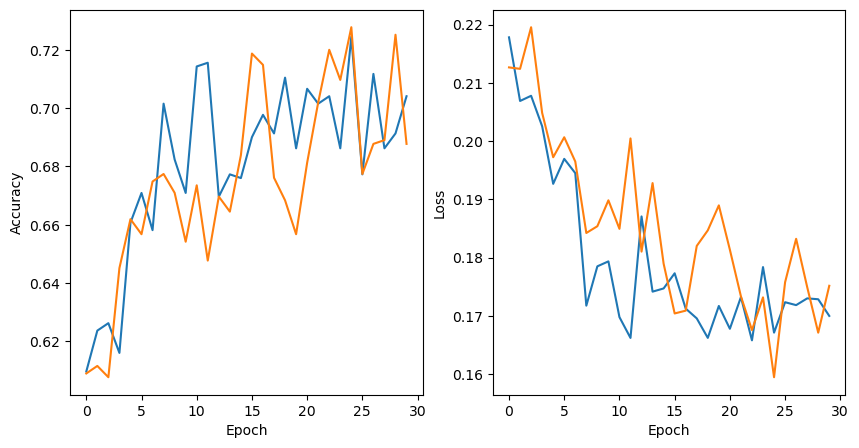

In [26]:
root_path='/kaggle/working'
epochs = 50
batch_size =16
zip_name="newtrain"
model = SiameseCNN()
print("Training:\n")
train(train_data, validation_data, model, epochs, batch_size, zip_name)

**Here we'll evauate the model and calculate its accuracy:**

In [25]:
batch_size = 16
triplet_loss = LossCalculation()
print("Evaluating:\n")
test_loader_object = PairDataSet("newtest", test_data, is_train = False)
test_loader = DataLoader(test_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)
run_testing(test_loader, model,triplet_loss)

Evaluating



Steps: 0it [00:00, ?it/s]

Test success: 0.57
